# Случайный лес для прогнозирования цены на основе характеристик

In [84]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pickle

In [2]:
data = pd.read_csv("https://raw.githubusercontent.com/AleksKids/hedonistic-demand-from-ebay/main/Preprocessing/Global/Global%20preprocessed.tsv", delimiter = '\t')

In [3]:
data

,Title,Price,Shipping_cost,Sales_Count,Sales_Value,Link,Condition,Seller Notes,Brand,Model,...,Dual-Band,FM,Global Version,HDMI Micro,Headphone Jack,Infrared,Lightning,Quad-Band,Tri-Band,Wireless charging
0,Apple iPhone 11 64GB Factory Unlocked 4G LTE S...,337.59,0.00,19787.0,6679958.00,https://www.ebay.com/itm/254604777645?nordt=tr...,Very Good - Refurbished,“This iPhone 11 is in Very Good condition and ...,apple,iPhone 11,...,0,0,0,0,0,0,0,0,0,0
1,Apple iPhone XR 64GB Factory Unlocked Smartpho...,266.28,0.00,12440.0,3312560.60,https://www.ebay.com/itm/254187678666?nordt=tr...,Very Good - Refurbished,“This Apple iPhone XR 64GB Factory Unlocked Sm...,apple,iPhone XR,...,0,0,0,0,0,0,0,0,0,0
2,Apple iPhone 11 64GB Unlocked Smartphone - Ver...,359.11,16.93,12224.0,4389742.37,https://www.ebay.com/itm/363183815277?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone 11,...,0,0,0,0,0,0,0,0,0,0
3,Apple iPhone X 64GB Factory Unlocked Phone - V...,231.98,16.50,11781.0,2732899.88,https://www.ebay.com/itm/382605209867?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone X,...,1,1,1,1,1,1,1,1,1,1
4,Apple iPhone X 256GB Unlocked Smartphone - Ver...,263.59,15.34,10020.0,2641203.85,https://www.ebay.com/itm/382446518910?nordt=tr...,Very Good - Refurbished,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone X,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3076,Samsung Galaxy Note8 SM-N950U - 64GB (Unlocked...,128.40,0.00,37.0,4750.91,https://www.ebay.com/itm/265635248944?nordt=tr...,Used,“These devices contain a SPOT on the display. ...,samsung,Samsung Galaxy Note8,...,0,0,0,0,0,0,0,0,0,0
3077,Brand New STALA509DCP TCL A3 32GB Storage 3GB ...,43.13,0.00,34.0,1466.36,https://www.ebay.com/itm/265731617536?nordt=tr...,New,"“This is a B+ Stock item, meaning unit is in v...",tcl,TCL A3,...,0,0,0,0,0,0,0,0,0,0
3078,Apple iPhone 12 Pro Max - 128GB - Fully Unlock...,554.31,0.00,37.0,20509.63,https://www.ebay.com/itm/265936106963?nordt=tr...,Used,“Phones Have Been Certified By Our Industry-Le...,apple,Apple iPhone 12 Pro Max,...,0,0,0,0,0,0,1,0,0,0
3079,Apple iPhone 13 Mini 128GB - T-Mobile / Metro ...,380.90,0.00,33.0,12569.67,https://www.ebay.com/itm/266138817726?nordt=tr...,Good - Refurbished,“LOCKED TO T-MOBILE Network - Fully tested 100...,apple,Apple iPhone 13 mini,...,0,0,0,0,0,0,0,0,0,0


## Предсказание цены по характеристикам (Гедонистическая цена)

In [4]:
y = data['Price']
X = data.drop(columns = ['Title', 'Price', 'Shipping_cost', 'Sales_Count', 'Sales_Value', 'Link', 'Seller Notes', 'Model','Lock Status', 'Contract', 'Model Number', 'Style', 'MPN', 'Connectivity', 'Features', 'Memory Card Type', 'Color'])

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=10)

In [6]:
categorical = list(X_train.dtypes[X_train.dtypes == "object"].index)
numeric = list(X_train.dtypes[X_train.dtypes == np.number].index)
X_train[categorical] = X_train[categorical]
X_test[categorical] = X_test[categorical]

In [7]:
column_transformer = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical),
    ('scaling', StandardScaler(), numeric)
])

pipeline = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer),
    ('regression', RandomForestRegressor())
])

In [18]:
model = pipeline.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Test RMSE = %.4f" % mean_squared_error(y_test, y_pred, squared=False))
print("Test MAE = %.4f" % mean_absolute_error(y_test, y_pred))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test, y_pred))

Test RMSE = 76.1821
Test MAE = 47.2833
Test MAPE = 0.3481


In [85]:
with open('Price Model.pkl','wb') as f:
    pickle.dump(model,f)

# Предсказывание объёма продаж в качестве аппроксимации общественной оценки

In [19]:
y2 = data['Sales_Value']
X2 = data.drop(columns = ['Title', 'Price', 'Shipping_cost', 'Sales_Count', 'Sales_Value', 'Link', 'Seller Notes', 'Model','Lock Status', 'Contract', 'Model Number', 'Style', 'MPN', 'Connectivity', 'Features', 'Memory Card Type', 'Color'])

In [20]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.3, random_state=10)

In [21]:
categorical2 = list(X_train2.dtypes[X_train2.dtypes == "object"].index)
numeric2 = list(X_train2.dtypes[X_train2.dtypes == np.number].index)
X_train2[categorical2] = X_train2[categorical2]
X_test2[categorical2] = X_test2[categorical2]

In [22]:
column_transformer2 = ColumnTransformer([
    ('ohe', OneHotEncoder(handle_unknown="ignore"), categorical2),
    ('scaling', StandardScaler(), numeric2)
])

pipeline2 = Pipeline(steps=[
    ('ohe_and_scaling', column_transformer2),
    ('regression', RandomForestRegressor())
])

In [23]:
model2 = pipeline2.fit(X_train2, y_train2)
y_pred2 = model2.predict(X_test2)
print("Test RMSE = %.4f" % mean_squared_error(y_test2, y_pred2, squared=False))
print("Test MAE = %.4f" % mean_absolute_error(y_test2, y_pred2))
print("Test MAPE = %.4f" % mean_absolute_percentage_error(y_test2, y_pred2))

Test RMSE = 156639.2966
Test MAE = 54612.1607
Test MAPE = 2.1282


In [86]:
with open('Sales Value Model.pkl','wb') as f:
    pickle.dump(model2,f)

In [52]:
data.loc[(np.abs((y_pred2-y_test2)/y_pred2)>1).index]

,Title,Price,Shipping_cost,Sales_Count,Sales_Value,Link,Condition,Seller Notes,Brand,Model,...,Dual-Band,FM,Global Version,HDMI Micro,Headphone Jack,Infrared,Lightning,Quad-Band,Tri-Band,Wireless charging
2556,Apple iPhone 12 Mini 5G 64GB Black - (AT&T) MG...,353.55,0.00,42.0,14849.00,https://www.ebay.com/itm/144769879900?nordt=tr...,New,"“This is a B+ Stock item, meaning unit is in v...",apple,Apple iPhone 12 mini,...,0,0,0,0,0,0,1,0,0,0
2433,Motorola Moto One 5G / 5G Ace | 64/128GB AT&T ...,209.38,5.70,46.0,9631.66,https://www.ebay.com/itm/265141840168?nordt=tr...,Used,“This listing is for the Motorola One 5G or 5G...,motorola,Moto One 5G or 5G Ace,...,0,0,0,0,0,0,0,0,0,0
263,Apple iPhone XR 64GB 128GB Fully Unlocked Smar...,200.33,14.99,486.0,97358.14,https://www.ebay.com/itm/265968892888?nordt=tr...,Good - Refurbished,“This Product has been determined fully functi...,apple,Apple iPhone XR,...,1,1,1,1,1,1,1,1,1,1
1277,Samsung Galaxy S9 PLUS G965U GSM Factory Unloc...,103.67,15.39,134.0,13891.23,https://www.ebay.com/itm/313643844119?nordt=tr...,Used,"“""Image Burn"" : This device (Usually used as ...",samsung,Samsung Galaxy S9+,...,0,0,0,0,0,0,0,0,0,0
1353,Wingtech Technology WTS98119FAN1RB Celero 5G 6...,75.75,0.00,130.0,9847.20,https://www.ebay.com/itm/115442037593?nordt=tr...,New,"“This is a B+ Stock item, meaning unit is in v...",wingtech technology,Apple iPhone 11,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
305,Samsung Galaxy Note 20 5G N981U (Unlocked) 128...,193.92,16.86,439.0,85131.61,https://www.ebay.com/itm/325349047528?nordt=tr...,Used,“Excessive wear on the body or screen. Device ...,samsung,Samsung Galaxy Note20 5G,...,0,0,0,0,0,0,0,0,0,0
1416,apple iPhone 7 32GB 128GB 256GB Unknown Carrie...,43.36,28.29,115.0,4986.53,https://www.ebay.com/itm/362495619840?nordt=tr...,For parts or not working,"“Selling as is maybe working, we received them...",apple,iPhone 7,...,0,0,0,0,0,0,0,0,0,0
1501,Samsung Galaxy S7 SM-G930T 32GB Gold Smartphon...,119.14,9.99,93.0,11080.45,https://www.ebay.com/itm/133603930223?nordt=tr...,Open box,“Samsung Certified Seller. Unlocked Samsung Ga...,samsung,Samsung Galaxy S7,...,0,0,0,0,0,0,0,0,0,0
2986,Samsung Galaxy A03S - SM-A037U - 32GB - GSM Un...,81.87,0.00,43.0,3520.24,https://www.ebay.com/itm/175328191200?nordt=tr...,Used,"“This is a B+ Stock item, meaning unit is in v...",samsung,Samsung Galaxy A03s,...,0,0,0,0,0,0,0,0,0,0


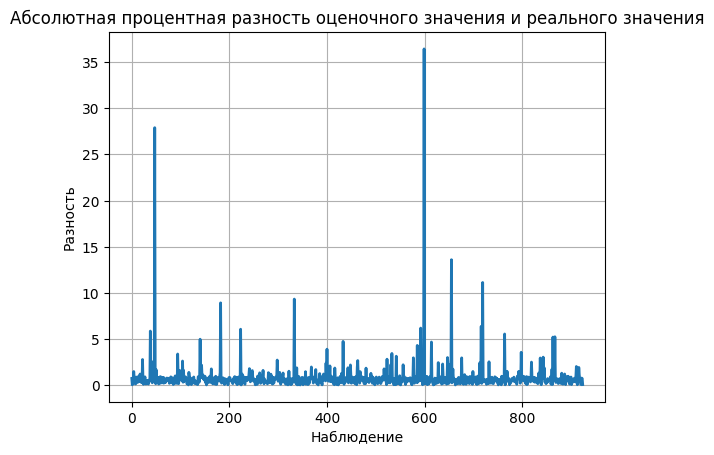

In [82]:
y_pred2_df = pd.DataFrame(y_pred2)
fig, ax = plt.subplots(1)
ax.plot(y_pred2_df.index, (np.abs((y_pred2-y_test2)/y_pred2)), lw=2)
ax.set_title(r'Абсолютная процентная разность оценочного значения и реального значения')
ax.set_xlabel('Наблюдение')
ax.set_ylabel('Разность')
ax.grid()

Есть выбросы. Клятые капиталисты завышают цены и народ ведётся.